In [98]:
!pip install chart_studio

In [99]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import plotly.io as pio
#pio.renderers.default = 'browser'

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')

In [100]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/09-26-2020.csv')

In [101]:
#Rename Country/Region to Country_Region
confirmed_df.rename(columns={"Country/Region": "Country_Region"}, inplace=True)
deaths_df.rename(columns={"Country/Region": "Country_Region"}, inplace=True)
recovered_df.rename(columns={"Country/Region": "Country_Region"}, inplace=True)


#Group by Country
df1 = confirmed_df.groupby('Country_Region').sum().reset_index()
df2 = deaths_df.groupby('Country_Region').sum().reset_index()
df3 = recovered_df.groupby('Country_Region').sum().reset_index()


#Melting confirm,death and recovered dateframe
world_confirmed_df =df1.melt(id_vars=['Country_Region', 'Lat', 'Long'], value_vars=df1.columns[4:], var_name='Date', value_name='Confirmed')
world_deaths_df = df2.melt(id_vars=['Country_Region','Lat', 'Long'], value_vars=df2.columns[4:], var_name='Date', value_name='Deaths')
world_recovered_df = df3.melt(id_vars=['Country_Region', 'Lat', 'Long'], value_vars=df3.columns[4:], var_name='Date', value_name='Recovered')

#Drop Lat & Long
world_confirmed_df.drop(['Lat', 'Long'], inplace=True, axis=1)
world_deaths_df.drop(['Lat', 'Long'], inplace=True, axis=1)
world_recovered_df.drop(['Lat', 'Long'], inplace=True, axis=1)

#Merging confirm,death and recovered dateframe
world_covid_df = world_confirmed_df.merge(world_recovered_df, on=['Country_Region','Date'])
world_covid_df = world_deaths_df.merge(world_covid_df, on=['Country_Region','Date'])
world_covid_df['Date'] = pd.to_datetime(world_covid_df['Date'],
                              format='%m/%d/%y')
#.dt.date

#Add New Cases
world_covid_df['Active']=world_covid_df['Confirmed']-world_covid_df['Recovered']-world_covid_df['Deaths']
world_covid_df['Active'] = world_covid_df['Active'].astype(int)

#Add Active Cases
world_covid_df['Prev_Confirmed'] = world_covid_df.groupby('Country_Region')['Confirmed'].shift(1)
world_covid_df['New Cases'] = world_covid_df['Confirmed'] - world_covid_df['Prev_Confirmed']
world_covid_df.drop('Prev_Confirmed',inplace = True,axis=1)
world_covid_df['New Cases'].fillna(0, inplace=True)

#Add New Recovered Cases
world_covid_df['Prev_Recovered'] = world_covid_df.groupby('Country_Region')['Recovered'].shift(1)
world_covid_df['New Recovered'] = world_covid_df['Recovered'] - world_covid_df['Prev_Recovered']
world_covid_df.drop('Prev_Recovered',inplace = True,axis=1)
world_covid_df['New Recovered'].fillna(0, inplace=True)

#Add New Deaths Cases
world_covid_df['Prev_Deaths'] = world_covid_df.groupby('Country_Region')['Deaths'].shift(1)
world_covid_df['New Deaths'] = world_covid_df['Deaths'] - world_covid_df['Prev_Deaths']
world_covid_df.drop('Prev_Deaths',inplace = True,axis=1)
world_covid_df['New Deaths'].fillna(0, inplace=True)

In [102]:
iran_df_data = world_covid_df [world_covid_df ['Country_Region'] == 'Iran']
#world_covid_df 
#usa_df_data
iran_df_data.reset_index(drop=True,inplace=True)

iran_df_data["Mortality Rate(per 100)"] = np.round(100*iran_df_data["Deaths"]/iran_df_data["Confirmed"],2)
iran_df_data["Recovered Rate(per 100)"] = np.round(100*iran_df_data["Recovered"]/iran_df_data["Confirmed"],2)
iran_df_data["Incidence Rate(per 100)"] = np.round(100*iran_df_data["New Cases"]/iran_df_data["Confirmed"],2)

iran_df_data['Mortality Rate(per 100)'] = iran_df_data['Mortality Rate(per 100)'].replace(np.nan, 0)
iran_df_data['Incidence Rate(per 100)'] = iran_df_data['Incidence Rate(per 100)'].replace(np.nan, 0)
iran_df_data['Recovered Rate(per 100)'] = iran_df_data['Recovered Rate(per 100)'].replace(np.nan, 0)

#iran_df_data.tail(5)

In [103]:
india_df_data = world_covid_df [world_covid_df ['Country_Region'] == 'India']
#world_covid_df 
#usa_df_data
india_df_data.reset_index(drop=True,inplace=True)

india_df_data["Mortality Rate(per 100)"] = np.round(100*india_df_data["Deaths"]/india_df_data["Confirmed"],2)
india_df_data["Recovered Rate(per 100)"] = np.round(100*india_df_data["Recovered"]/india_df_data["Confirmed"],2)
india_df_data["Incidence Rate(per 100)"] = np.round(100*india_df_data["New Cases"]/india_df_data["Confirmed"],2)

india_df_data['Mortality Rate(per 100)'] = india_df_data['Mortality Rate(per 100)'].replace(np.nan, 0)
india_df_data['Incidence Rate(per 100)'] = india_df_data['Incidence Rate(per 100)'].replace(np.nan, 0)
india_df_data['Recovered Rate(per 100)'] = india_df_data['Recovered Rate(per 100)'].replace(np.nan, 0)

#india_df_data.tail(5)

In [104]:
india_confirmed = pd.Series(india_df_data['Confirmed'].tail(1).values)
india_active = pd.Series(india_df_data['Active'].tail(1).values)
india_recovered = pd.Series(india_df_data['Recovered'].tail(1).values)
india_deaths = pd.Series(india_df_data['Deaths'].tail(1).values)
date_t = pd.Series(india_df_data['Date'].tail(1).values)


In [105]:
iran_confirmed = pd.Series(iran_df_data['Confirmed'].tail(1).values)
iran_active = pd.Series(iran_df_data['Active'].tail(1).values)
iran_recovered = pd.Series(iran_df_data['Recovered'].tail(1).values)
iran_deaths = pd.Series(iran_df_data['Deaths'].tail(1).values)


# Research about the recent cases of COVID-19 in India and Iran

A novel Corona virus is a category of pathogens, which mostly attacks on the respiratory system of human beings. Corona virus outbreaks are emerging earlier also in the form of Severe Acute Respiratory Syndrome (SARS) and Middle East Respiratory Syndrome (MERS).Now, in the present times, it emerges as a COVID-19, which is caused by the SARS2 Coronavirus and poses a significant risk to the human race. 

In December 2019, a number of patients with pneumonia symptoms were reported in Wuhan and Hubei Province of China and later identified as symptoms caused due to the spread of corona virus. Epidemiologically, these patients were later on found to be linked to an animal and seafood market of Wuhan. Later on, the Wuhan city of China was recognized as the epicentre of the COVID-19 disease and claimed for spreading the disease across the world. Around 41 lab confirmed COVID-19 patients reported and admitted to hospital up to January 2, 2020 in China. These patients have symptoms of coughing, sneezing, breathing problems, chest pain, indigestion, and respiratory illness. It was also observed that most of these patients are already suffering from varied diseases such as hypertension, diabetes and cardiovascular.     

According to China National Health Commission, 17 deaths reported in China with COVID-19 up to January 22, 2020 and within four days death rate raised to triple with 5502 confirmed cases. By the end of January 2020, 7734 confirmed cases have been reported in China along with 90 cases in other countries such as Thailand, Japan, Malaysia, Iran, Italy, India, USA, Canada, Taiwan, Vietnam, France, Nepal, Cambodia, Germany, Singapore, Korea, United Arab Emirates, Sri Lanka, The Philippines, Australia and Finland. 

Furthermore, WHO on 30 Jan declares Public health emergency of international concern due to the severity of the disease. The International Committee on Taxonomy of Viruses named this corona virus as a Severe Acute Respiratory Syndrome Coronavirus-2 (SARS-CoV-2) and the disease caused by the virus designated as Coronavirus Disease-19 (COVID-19) by WHO. The COVID-19 has strewed in more than 114 countries with 118,326 active cases and 4292 deaths on March 11, 2020 and declared as pandemic by WHO. The situation becomes worse within a week after the pandemic declaration and Italy become the second most affected country after china. 

###### Presently, about 216 countries are affected by COVID-19 across the globe and shattered the economic growth of developed as well as developing countries. The WHO report documented on 05 October 2020 claimed 7,637,066 cases United States of America, 6,626,291 cases in India, 4,915,289 in Brazil, 1,225,889 in Russia, 855,052 cases in Colombia, much higher cases in comparison to China from where the disease actually originated (85,470)

To assess the recent cases of COVID-19 in India and Iran, the epidemic dynamics of COVID-19 cases in both countries in terms of Confimed Case Rate (CCR), Case Recovery Rate (CRR) and Death Rate (DR) COVID-19 have been evaluated during Lockdown-1.

In [106]:
print("A total of {a} COVID-19 confirmed cases have been reported in Indian \
as from {date} with {b} active cases ({ap:.1f}%),{c} cured/discharged ({rp:.1f}%),\
and {d} deaths ({dp:.1f}%).".format(a = india_confirmed[0],date = date_t[0].strftime("%d. %B %Y"),b = india_active[0],ap=(india_active[0]/india_confirmed[0])*100 \
                                    ,c = india_recovered[0],rp=(india_recovered[0]/india_confirmed[0])*100 \
                                    ,d = india_deaths[0],dp=(india_deaths[0]/india_confirmed[0])*100))

print("\nA total of {a} COVID-19 confirmed cases have been reported in Iran as from {date}  with  {b}  active cases ({ap:.1f}%),{c} cured/discharged ({rp:.1f}%),\
and {d} deaths ({dp:.1f}%).".format(a = iran_confirmed[0],date = date_t[0].strftime("%d. %B %Y"),b = iran_active[0],ap=(iran_active[0]/iran_confirmed[0])*100 \
                                    ,c = iran_recovered[0],rp=(iran_recovered[0]/iran_confirmed[0])*100 \
                                    ,d = iran_deaths[0],dp=(iran_deaths[0]/iran_confirmed[0])*100))

A total of 6835655 COVID-19 confirmed cases have been reported in Indian as from 07. October 2020 with 902425 active cases (13.2%),5827704 cured/discharged (85.3%),and 105526 deaths (1.5%).

A total of 483844 COVID-19 confirmed cases have been reported in Iran as from 07. October 2020  with  59077  active cases (12.2%),397109 cured/discharged (82.1%),and 27658 deaths (5.7%).


# Read news every day, collect the data and update the dataset till next week 

## Collect the dataset

In [107]:
india_data_state_wise = pd.read_csv('/content/covid_19_india_df.csv',index_col=0)
#Drop Unknown &  Unassigned
df_deffer = india_data_state_wise['Province_State']=='Unknown' 
india_data_state_wise.drop(india_data_state_wise[df_deffer].index,inplace=True)
df_deffer = india_data_state_wise['Province_State']=='Unassigned' 
india_data_state_wise.drop(india_data_state_wise[df_deffer].index,inplace=True)
india_data_state_wise.tail()

,Date,Province_State,Recovered,Deaths,Confirmed,Active
6817,2020-09-28,Telangana,156431,1107,187211,29673.0
6818,2020-09-28,Tripura,18959,273,24921,5689.0
6820,2020-09-28,Uttar Pradesh,325888,5594,387085,55603.0
6821,2020-09-28,Uttarakhand,35672,574,47045,10799.0
6822,2020-09-28,West Bengal,216921,4781,247425,25723.0


## Update the dataset till next week

In [108]:
df_data1 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/09-28-2020.csv')
df_data2 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/09-29-2020.csv')
df_data3 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/09-30-2020.csv')
df_data4 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-01-2020.csv')
df_data5 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-02-2020.csv')
df_data6 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-03-2020.csv')
df_data7 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-04-2020.csv')
df_data8 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-05-2020.csv')
df_data9 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-06-2020.csv')

frames = [df_data1 , df_data2, df_data3, df_data4, df_data5, df_data6, df_data7, df_data8, df_data9 ] 

res1 = pd.concat(frames)
res1.drop(['FIPS','Admin2'], axis = 1,inplace=True) 

df_dataset1 = res1[res1['Country_Region'] == 'India']

df_dataset1.rename(columns = {'Last_Update':'Date'}, inplace = True) 
df_dataset1.drop(['Combined_Key','Lat', 'Long_','Incidence_Rate', 'Case-Fatality_Ratio'], axis = 1,inplace=True) 
df_dataset1.drop(['Country_Region'], axis = 1,inplace=True) 

df_dataset1['Date'] = pd.to_datetime(df_dataset1['Date'],
                              format='%Y-%m-%d').dt.date

frames = [india_data_state_wise , df_dataset1] 
new_data_india = pd.concat(frames)

In [109]:
#Drop Unknown &  Unassigned
df_deffer = new_data_india['Province_State']=='Unknown' 
new_data_india.drop(new_data_india[df_deffer].index,inplace=True)
df_deffer = new_data_india['Province_State']=='Unassigned' 
new_data_india.drop(new_data_india[df_deffer].index,inplace=True)
new_data_india.reset_index(drop=True,inplace=True) 
new_data_india.tail()

,Date,Province_State,Recovered,Deaths,Confirmed,Active
7112,2020-10-07,Telangana,177008,1189,204748,26551.0
7113,2020-10-07,Tripura,22623,301,27545,4621.0
7114,2020-10-07,Uttar Pradesh,370753,6153,420937,44031.0
7115,2020-10-07,Uttarakhand,43238,677,52329,8414.0
7116,2020-10-07,West Bengal,243743,5318,277049,27988.0


# Find the total number of COVID-19 cases in India till date

In [110]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india_latest = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_deffer = df_india_latest['state']=='State Unassigned' 
df_india_latest.drop(df_india_latest[df_deffer].index,inplace=True)
df_india_latest.sort_values(by=['confirmed'], ascending=False).head(5)

df_india_latest["Mortality Rate(per 100)"]= np.round(np.nan_to_num(100*df_india_latest["deaths"]/df_india_latest["confirmed"]),2)


In [111]:
print("{a} is the total number of COVID-19 confirmed cases in India till \
date.".format(a = df_india_latest['confirmed'].sum()))

6903806 is the total number of COVID-19 confirmed cases in India till date.


# Which state is the most recent with COVID-19 case?

In [112]:
top_state = df_india_latest.head(1)
#top_state
print("{state_name[0]} state is the most recent with COVID-19 cases {num_cases[0]}".format(state_name = top_state['state'],num_cases=top_state['confirmed']))

Maharashtra state is the most recent with COVID-19 cases 1493884


# What is the total number of active COVID-19 cases in India?

In [113]:
print("{a} is the total number of active COVID-19 cases in India.".format(a = df_india_latest['active'].sum()))

893031 is the total number of active COVID-19 cases in India.


# Create multiple visualization and compare the spread of COVID-19 in India with Iran.

In [114]:

temp = [iran_df_data,india_df_data]
temp = pd.concat(temp)
temp_new = temp.melt(id_vars=['Country_Region','Date'], value_vars=['Confirmed','Recovered','Deaths','Active'],var_name='Case', value_name='Count')

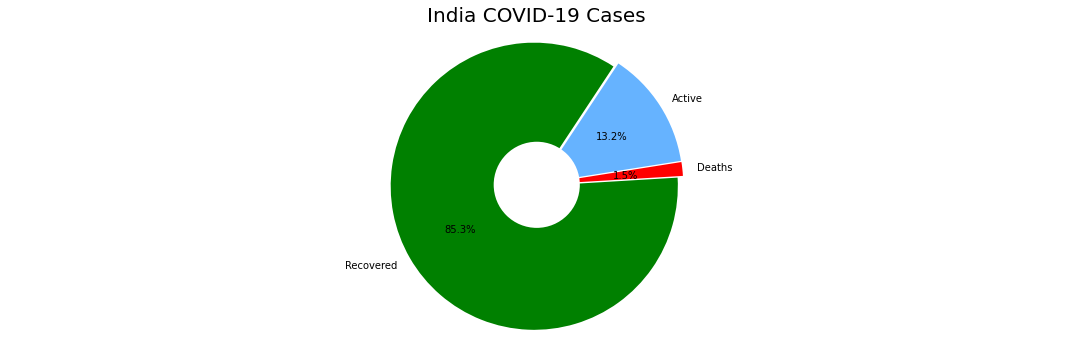

In [115]:
labels = ['Active','Recovered','Deaths']
sizes = [india_active,india_recovered,india_deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.02)

plt.figure(figsize= (15,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.30,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()



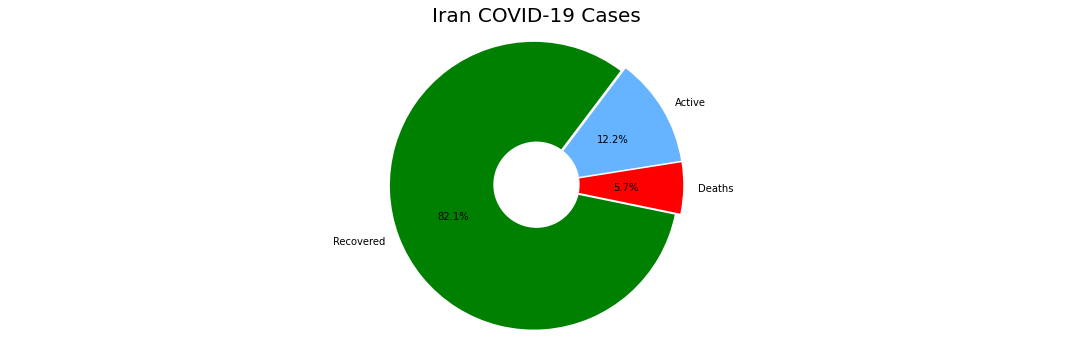

In [116]:
labels = ['Active','Recovered','Deaths']
sizes = [iran_active,iran_recovered,iran_deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.02)

plt.figure(figsize= (15,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.30,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Iran COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()



## India vs Iran growth of COVID19 over time

In [117]:
data_df1 = temp_new[temp_new["Case"]=='Confirmed']
fig = px.line(data_df1, x="Date", y="Count", color='Country_Region', 
                  height=600, title='Confirmed', 
                  color_discrete_sequence = ["black","lightgrey"])
fig.update_layout(title="India vs Iran Covid-19 Confirmed Cases", xaxis_title="", yaxis_title="")
fig.show()

In [118]:
data_df1 = temp_new[temp_new["Case"]=='Active']
fig = px.line(data_df1, x="Date", y="Count", color='Country_Region', 
                  height=600, 
                  color_discrete_sequence = ["olive","darkseagreen"])
fig.update_layout(title="India vs Iran Covid-19 Active Cases", xaxis_title="", yaxis_title="")
fig.show()

In [119]:
data_df1 = temp_new[temp_new["Case"]=='Recovered']
fig = px.line(data_df1, x="Date", y="Count", color='Country_Region', 
                  height=600, 
                  color_discrete_sequence = ["green","yellowgreen"])
fig.update_layout(title="India vs Iran Covid-19 Recovered Cases", xaxis_title="", yaxis_title="")
fig.show()

In [120]:
data_df1 = temp_new[temp_new["Case"]=='Deaths']
fig = px.line(data_df1, x="Date", y="Count", color='Country_Region', 
                  height=600, 
                  color_discrete_sequence = ["red","orange"])
fig.update_layout(title="India vs Iran Covid-19 Deaths Cases", xaxis_title="", yaxis_title="")
fig.show()

## Daily Cases Wise

In [121]:
temp2 = [iran_df_data,india_df_data]
temp2 = pd.concat(temp2)
temp_new2 = temp2.melt(id_vars=['Country_Region','Date'], value_vars=['New Cases','New Deaths'],var_name='New Case', value_name='Count')
#temp_new2

In [122]:
data_df1 = temp_new2[temp_new2["New Case"]=='New Cases']
fig = px.line(data_df1, x="Date", y="Count", color='Country_Region', 
                  height=600,
                  color_discrete_sequence = ["black","grey"])
fig.update_layout(title="India vs Iran Covid-19 Daily New Confirmed Cases", xaxis_title="", yaxis_title="")
fig.show()

In [123]:
df1 = temp_new2[temp_new2["New Case"]=='New Deaths']
fig = px.line(df1, x="Date", y="Count", color='Country_Region', 
                  height=600, title='Confirmed', 
                  color_discrete_sequence = ["brown","lightcoral"])
fig.update_layout(title="India vs Iran Covid-19 Daily New Deaths Cases", xaxis_title="", yaxis_title="")
fig.show()


## Mortality Rate (per 100)

In [124]:
temp3 = [iran_df_data,india_df_data]
temp3 = pd.concat(temp3)
temp_new3 = temp3.melt(id_vars=['Country_Region','Date'], value_vars=["Mortality Rate(per 100)","Recovered Rate(per 100)","Incidence Rate(per 100)"],var_name='Cases Rates', value_name='Count')
#temp_new3

In [125]:
df1 = temp_new3[temp_new3["Cases Rates"]=='Mortality Rate(per 100)']
fig = px.line(df1, x="Date", y="Count", color='Country_Region', 
                  height=600, 
                  color_discrete_sequence = ["deeppink","crimson"])
fig.update_layout(title="India vs Iran Covid-19 Mortality Rate (per 100)", xaxis_title="", yaxis_title="")
fig.show()

## Recovered Rate (per 100)

In [126]:
df1 = temp_new3[temp_new3["Cases Rates"]=='Recovered Rate(per 100)']
fig = px.line(df1, x="Date", y="Count", color='Country_Region', 
                  height=600, 
                  color_discrete_sequence = ["forestgreen","darkseagreen"])
fig.update_layout(title="India vs Iran Covid-19 Recovered Rate (per 100)", xaxis_title="", yaxis_title="")
fig.show()

## Incidence Rate (per 100)

In [127]:
df1 = temp_new3[temp_new3["Cases Rates"]=='Incidence Rate(per 100)']
fig = px.line(df1, x="Date", y="Count", color='Country_Region', 
                  height=600, 
                  color_discrete_sequence = ["lightseagreen","blue"])
fig.update_layout(title="India vs Iran Covid-19 Incidence Rate (per 100)", xaxis_title="", yaxis_title="")
fig.show()

# Use Prophet to forecast the data for next 10 days with 97% confidence interval

## Prediction Curve for India Confirmed Cases (10 Days)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


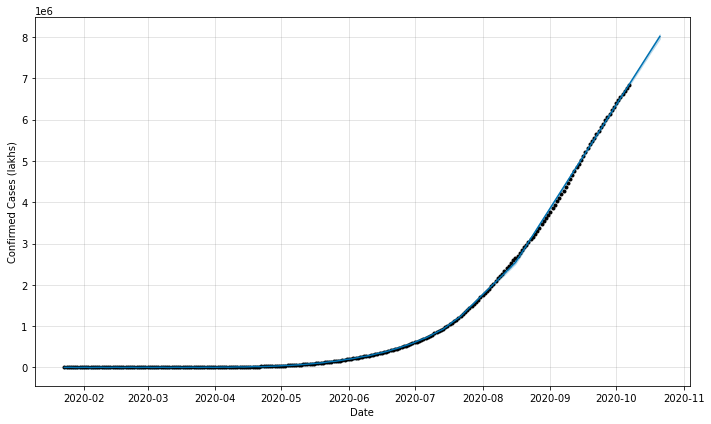

In [128]:
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = india_df_data['Date']
#dates
data['y'] = india_df_data['Confirmed']
#df_india_days
#data

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=14)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(14)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases (lakhs)')

In [129]:
prop_forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,273.0,273.0,273.0,2.730000e+02
mean,1.585391e+06,1.549146e+06,1.621220e+06,1.584470e+06,1.586193e+06,1.097682e-10,1.097682e-10,1.097682e-10,1.097682e-10,1.097682e-10,1.097682e-10,0.0,0.0,0.0,1.585391e+06
std,2.319903e+06,2.318681e+06,2.320831e+06,2.317445e+06,2.322056e+06,1.640856e+03,1.640856e+03,1.640856e+03,1.640856e+03,1.640856e+03,1.640856e+03,0.0,0.0,0.0,2.319879e+06
min,-1.069039e+03,-4.131357e+04,3.072974e+04,-1.069039e+03,-1.069039e+03,-2.397450e+03,-2.397450e+03,-2.397450e+03,-2.397450e+03,-2.397450e+03,-2.397450e+03,0.0,0.0,0.0,-3.296676e+03
25%,2.424658e+03,-3.254181e+04,3.890592e+04,2.424658e+03,2.424658e+03,-1.435775e+03,-1.435775e+03,-1.435775e+03,-1.435775e+03,-1.435775e+03,-1.435775e+03,0.0,0.0,0.0,3.032515e+03
50%,2.547497e+05,2.221408e+05,2.919181e+05,2.547497e+05,2.547497e+05,-1.142773e+02,-1.142773e+02,-1.142773e+02,-1.142773e+02,-1.142773e+02,-1.142773e+02,0.0,0.0,0.0,2.569953e+05
75%,2.432275e+06,2.396652e+06,2.469920e+06,2.432275e+06,2.432275e+06,1.970620e+03,1.970620e+03,1.970620e+03,1.970620e+03,1.970620e+03,1.970620e+03,0.0,0.0,0.0,2.433139e+06
max,8.018212e+06,7.958585e+06,8.071693e+06,7.969466e+06,8.059884e+06,2.245648e+03,2.245648e+03,2.245648e+03,2.245648e+03,2.245648e+03,2.245648e+03,0.0,0.0,0.0,8.016776e+06


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


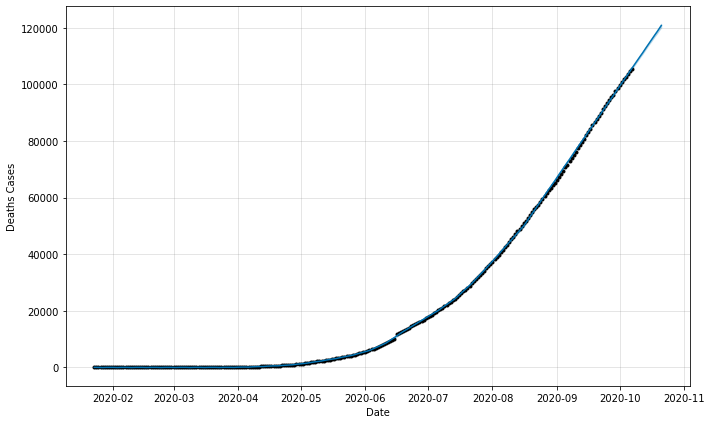

In [130]:
data2 = pd.DataFrame(columns = ['ds','y'])
data2['ds'] = india_df_data['Date']
#dates
data2['y'] = india_df_data['Deaths']
#df_india_days
#data

prop=Prophet()
prop.fit(data2)
future=prop.make_future_dataframe(periods=14)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(14)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Deaths Cases')

In [131]:
prop_forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,273.000000,273.000000,273.000000,273.000000,273.000000,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,273.0,273.0,273.0,273.000000
mean,27927.145282,27577.496451,28278.538806,27916.197524,27938.744339,9.845442e-13,9.845442e-13,9.845442e-13,9.845442e-13,9.845442e-13,9.845442e-13,0.0,0.0,0.0,27927.145282
std,36353.994685,36341.786265,36367.523608,36326.883817,36382.750483,2.384973e+01,2.384973e+01,2.384973e+01,2.384973e+01,2.384973e+01,2.384973e+01,0.0,0.0,0.0,36353.752555
min,-7.930503,-416.156084,281.183026,-7.930503,-7.930503,-5.220302e+01,-5.220302e+01,-5.220302e+01,-5.220302e+01,-5.220302e+01,-5.220302e+01,0.0,0.0,0.0,-59.151840
25%,47.429094,-283.292421,413.871684,47.429094,47.429094,-8.314479e+00,-8.314479e+00,-8.314479e+00,-8.314479e+00,-8.314479e+00,-8.314479e+00,0.0,0.0,0.0,44.370179
50%,7291.256674,6919.956335,7641.524027,7291.256674,7291.256674,8.922940e+00,8.922940e+00,8.922940e+00,8.922940e+00,8.922940e+00,8.922940e+00,0.0,0.0,0.0,7282.942194
75%,48332.952795,48000.152195,48691.268605,48332.952795,48332.952795,2.092925e+01,2.092925e+01,2.092925e+01,2.092925e+01,2.092925e+01,2.092925e+01,0.0,0.0,0.0,48356.024801
max,120773.288170,120098.352574,121452.440494,120162.944023,121391.883683,2.307201e+01,2.307201e+01,2.307201e+01,2.307201e+01,2.307201e+01,2.307201e+01,0.0,0.0,0.0,120783.940388


## Prediction Curve for Iran Confirmed Cases (10 Days)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


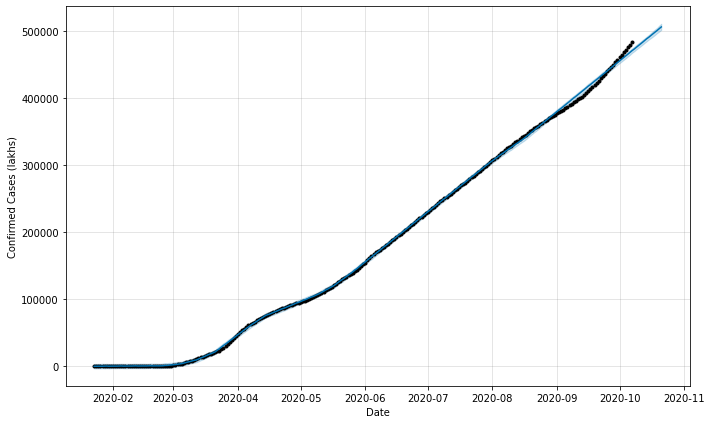

In [132]:
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = iran_df_data['Date']
#dates
data['y'] = iran_df_data['Confirmed']


prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=14)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(14)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases (lakhs)')

In [133]:
prop_forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,273.000000,273.000000,273.000000,273.000000,273.000000,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,273.0,273.0,273.0,273.000000
mean,196653.244430,193244.669571,200095.161629,196595.539812,196710.312642,-4.376735e-12,-4.376735e-12,-4.376735e-12,-4.376735e-12,-4.376735e-12,-4.376735e-12,0.0,0.0,0.0,196653.244430
std,161691.346718,161652.273651,161730.000672,161583.556020,161798.475094,8.585603e+01,8.585603e+01,8.585603e+01,8.585603e+01,8.585603e+01,8.585603e+01,0.0,0.0,0.0,161692.739804
min,-357.954443,-3847.087557,3054.581178,-357.954443,-357.954443,-9.619937e+01,-9.619937e+01,-9.619937e+01,-9.619937e+01,-9.619937e+01,-9.619937e+01,0.0,0.0,0.0,-454.153817
25%,44494.375993,41173.922158,48008.492774,44494.375993,44494.375993,-6.823784e+01,-6.823784e+01,-6.823784e+01,-6.823784e+01,-6.823784e+01,-6.823784e+01,0.0,0.0,0.0,44531.526574
50%,170288.796086,166600.762806,173496.895816,170288.796086,170288.796086,-1.401182e+01,-1.401182e+01,-1.401182e+01,-1.401182e+01,-1.401182e+01,-1.401182e+01,0.0,0.0,0.0,170220.558250
75%,334977.801735,331658.434646,338539.611451,334977.801735,334977.801735,3.715058e+01,3.715058e+01,3.715058e+01,3.715058e+01,3.715058e+01,3.715058e+01,0.0,0.0,0.0,334994.803356
max,505870.575908,501559.403582,510954.486566,502751.415590,508847.938836,1.802769e+02,1.802769e+02,1.802769e+02,1.802769e+02,1.802769e+02,1.802769e+02,0.0,0.0,0.0,506050.852792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


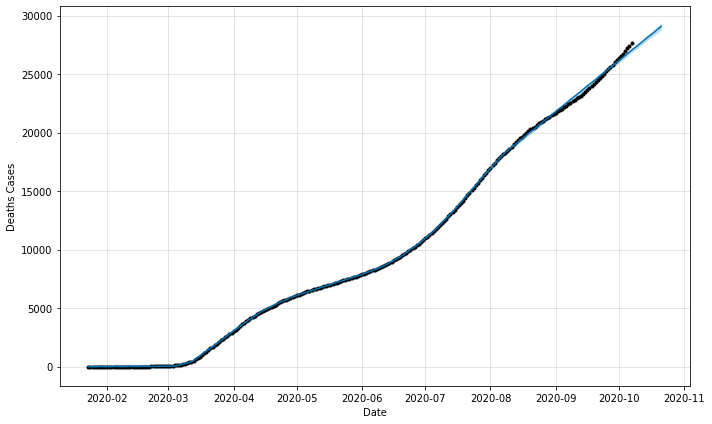

In [134]:
data2 = pd.DataFrame(columns = ['ds','y'])
data2['ds'] = iran_df_data['Date']
#dates
data2['y'] = iran_df_data['Deaths']
#df_india_days
#data

prop=Prophet()
prop.fit(data2)
future=prop.make_future_dataframe(periods=14)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(14)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Deaths Cases')

In [135]:
prop_forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,273.000000,273.000000,273.000000,273.000000,273.000000,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,273.0,273.0,273.0,273.000000
mean,10946.524342,10794.226868,11099.344589,10942.450813,10950.237691,-1.315285e-13,-1.315285e-13,-1.315285e-13,-1.315285e-13,-1.315285e-13,-1.315285e-13,0.0,0.0,0.0,10946.524342
std,9179.013778,9175.531501,9182.950562,9171.177155,9186.209637,7.406375e+00,7.406375e+00,7.406375e+00,7.406375e+00,7.406375e+00,7.406375e+00,0.0,0.0,0.0,9179.130076
min,-16.246589,-171.107125,123.966515,-16.246589,-16.246589,-9.809729e+00,-9.809729e+00,-9.809729e+00,-9.809729e+00,-9.809729e+00,-9.809729e+00,0.0,0.0,0.0,-23.746041
25%,2899.755091,2767.655016,3057.534047,2899.755091,2899.755091,-6.737517e+00,-6.737517e+00,-6.737517e+00,-6.737517e+00,-6.737517e+00,-6.737517e+00,0.0,0.0,0.0,2906.085835
50%,8281.054592,8122.460624,8424.142125,8281.054592,8281.054592,-1.059675e-01,-1.059675e-01,-1.059675e-01,-1.059675e-01,-1.059675e-01,-1.059675e-01,0.0,0.0,0.0,8274.317075
75%,19172.160217,19024.228877,19320.621705,19172.160217,19172.160217,6.330744e+00,6.330744e+00,6.330744e+00,6.330744e+00,6.330744e+00,6.330744e+00,0.0,0.0,0.0,19167.910437
max,29045.823053,28779.724565,29304.681710,28834.578894,29240.000368,1.347579e+01,1.347579e+01,1.347579e+01,1.347579e+01,1.347579e+01,1.347579e+01,0.0,0.0,0.0,29059.298844


# Write down your inference after plotting the visualization. Tell us if trend of COVID-19 in India is similar to Iran

## Iran

- Our  estimation  show  that  the  COVID-19  epidemic  trend  in  Iran will  rise  from  March  8,  2020  and will  peak  during  March  15  to  21, and there  will  be  a  decreasing  trend  from  22  to  29 March 2020.
- Under  such circumstances,  two  types  of  hypotheses  can  be  considered  for  the  adequacy of  the current  measures  and  as  to  whether  the  epidemic  peak  will  occur  during  March  15-21,  2020.
- Assuming  that  the  current  measures  are  inefficient  and  inadequate, the  number  of  estimated  cases will  continue  to  increase  by  the  end  of  Oct.
- The  current  control  measures are  effective  and  sufficient  and  the number  of  cases  estimated  after  the  epidemic  peak  will  go down.   This   model   may   be  close   to   reality   if   intervention   measures   continue   at  the  current intensity .  
- At  the  time  of  the  outbreak  of  COVID-19, the best and most urgent steps must be taken to overcome the coronavirus epidemic.   The   fight against coronavirus   infection should be an emergency.

## India

- Our  estimation  show  that  the  COVID-19  epidemic  trend  in  India will  rise  from  Feb  28,  2020  and will  peak  during  May  15  to  June 15.
- Under  such circumstances,  two  types  of  hypotheses  can  be  considered  for  the  adequacy of  the current  measures  and  as  to  whether  the  epidemic  peak  will  occur  during  June  15-31,  2020.
- Assuming  that  the  current  measures  are inefficient  and  inadequate, the  number  of  estimated  cases will  continue  to  increase  by  the  end  of  Oct.
- The  current  control  measures are  effective  and  sufficient  and  the number  of  cases  estimated  after  the  epidemic  peak  will  go down.   
- At  the  time  of  the  outbreak  of  COVID-19, the best and most urgent steps must be taken to overcome the coronavirus epidemic.   The   fight against coronavirus   infection should be an emergency.

## The trend of COVID-19 in India is not similar to Iran
##### Our estimation show that the COVID-19 epidemic trend in India will rise from Feb 28, 2020 and will peak during May 15 to June 15. then the COVID-19 epidemic trend in Iran will rise from March 8, 2020 and will peak during March 15 to 21, and there will be a decreasing trend from 22 to 29 March 2020.


# Write down a theory to justify your inference.


##### This study presented a comprehensive analysis of the COVID-19 outbreak situation in India & Iran.
##### The  cases  are  rising  very  fast  and  they  need  aggressive  control  strategies from  the  Administrative unit of India & Iran. There are six different aspects covered up in this study and six re-search  questions  have  been  answered  comprehensively.  They  are  related to  presenting  the growth trends of infected cases in India & Iran, predictions for the number of infected cases for next 10-14  days,  impact  of  social  distancing  on  the  citizens  of  India & Iran,  impact  of mass  events  on  the number of infected cases in India & Iran, network analysis and mining of patterns on the patients suf-fering from coronavirus, and analyzing the strategies for uplifting lockdown in India.
##### The current study implemented various techniques to present the analysis . This study will also be favorable for the administrative units of other countries to consider various aspects related to the control of COVID-19 outspread in their respective regions.

### Stay Home Stay Safe
The humanitarian cost of the coronavirus outbreak continues to rise. Hundreds of thousands of cases & thousands of virus-related deaths have been reported. Drawing on real-time data, we made live charts available to track the spread of the pandemic around the world.


See the latest information from the World Health Organization so you can help prevent the spread of coronavirus.

In [136]:
!git init

Reinitialized existing Git repository in /content/.git/


In [137]:
!git config --global user.email “rajabhijeet22009@gmail.com”
!git config --global user.name “abhijeetraj22”

In [144]:
!git add -A

In [146]:
!git commit -m “Research-on-India-and-Iran”

On branch master
nothing to commit, working tree clean


In [140]:
!git remote add origin https://<abhijeetraj22>:<Raj@220995>github@github.com/abhijeetraj22/Research-on-India-and-Iran.git

/bin/bash: abhijeetraj22: No such file or directory


In [141]:
!git push -u origin master

fatal: 'origin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [142]:
!git remote rm origin

fatal: No such remote: origin
